In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

# Initialize a Spark session
spark = SparkSession \
    .builder \
    .appName("KafkaReadTest") \
    .getOrCreate()

# Read from Kafka topic as a batch dataframe
df = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "52.27.188.150:9092") \
    .option("subscribe", "bigdata-project2") \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", """{"bigdata-project2":{"0":10}}""") \
    .load()

# Select and cast the key and value columns from Kafka's binary format
df = df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

# Show the first 10 messages
df.show(10, truncate=False)



+----+--------------------------------------------------------------------+
|key |value                                                               |
+----+--------------------------------------------------------------------+
|null|2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0   |
|null|3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0       |
|null|4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0     |
|null|5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0     |
|null|6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0        |
|null|8.0,51.0,Male,33.0,25.0,9.0,26.0,Premium,Annual,129.0,8.0,1.0       |
|null|9.0,58.0,Female,49.0,12.0,3.0,16.0,Standard,Quarterly,821.0,24.0,1.0|
|null|10.0,55.0,Female,37.0,8.0,4.0,15.0,Premium,Annual,445.0,30.0,1.0    |
|null|11.0,39.0,Male,12.0,5.0,7.0,4.0,Standard,Quarterly,969.0,13.0,1.0   |
|null|12.0,64.0,Female,3.0,25.0,2.0,11.0,Standard,Quarterly,415.0,29.0,1.0|
+----+------

In [0]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession \
    .builder \
    .appName("KafkaReadTest") \
    .getOrCreate()

# Read from Kafka topic
df = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "52.27.188.150:9092") \
    .option("subscribe", "bigdata-project2") \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load()

# Count the number of messages
message_count = df.count()

print(f"Number of messages in the topic 'bigdata-project2': {message_count}")




Number of messages in the topic 'bigdata-project1': 505207


In [0]:
from pyspark.sql.functions import split

# Split the 'value' column into separate columns based on the provided schema
split_cols = split(df['value'], ',')

df = df.withColumn('CustomerID', split_cols.getItem(0).cast('integer'))
df = df.withColumn('Age', split_cols.getItem(1).cast('integer'))
df = df.withColumn('Gender', split_cols.getItem(2))
df = df.withColumn('Tenure', split_cols.getItem(3).cast('integer'))
df = df.withColumn('Usage Frequency', split_cols.getItem(4).cast('integer'))
df = df.withColumn('Support Calls', split_cols.getItem(5).cast('integer'))
df = df.withColumn('Payment Delay', split_cols.getItem(6).cast('integer'))
df = df.withColumn('Subscription Type', split_cols.getItem(7))
df = df.withColumn('Contract Length', split_cols.getItem(8))
df = df.withColumn('Total Spend', split_cols.getItem(9).cast('float'))
df = df.withColumn('Last Interaction', split_cols.getItem(10).cast('integer'))
df = df.withColumn('Churn', split_cols.getItem(11).cast('integer'))

# Drop the original 'key' and 'value' columns
df = df.drop('key', 'value')

# Show the transformed DataFrame
df.show()


+----------------+---------+------+--------------------+-------------+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|           topic|partition|offset|           timestamp|timestampType|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------------+---------+------+--------------------+-------------+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|bigdata-project2|        0|     0|2023-11-14 22:01:...|            0|         2| 30|Female|    39|             14|            5|           18|         Standard|         Annual|      932.0|              17|    1|
|bigdata-project2|        0|     1|2023-11-14 22:01:...|            0|         3| 65|Female|    49|              1|           10|            8|     

In [0]:
# Show summary statistics
df.describe().show()

# Count the number of distinct values in each column
for col in df.columns:
    print(f"Distinct values in {col}: {df.select(col).distinct().count()}")


+-------+----------------+---------+------------------+-------------+------------------+------------------+------+------------------+------------------+------------------+------------------+-----------------+---------------+------------------+------------------+-------------------+
|summary|           topic|partition|            offset|timestampType|        CustomerID|               Age|Gender|            Tenure|   Usage Frequency|     Support Calls|     Payment Delay|Subscription Type|Contract Length|       Total Spend|  Last Interaction|              Churn|
+-------+----------------+---------+------------------+-------------+------------------+------------------+------+------------------+------------------+------------------+------------------+-----------------+---------------+------------------+------------------+-------------------+
|  count|          505207|   505207|            505207|       505207|            505206|            505206|505207|            505206|            505206

In [0]:
# Check the distinct values in the 'Churn' column
df.select('Churn').distinct().show()

# Handling the extra category in 'Churn' (assuming it's due to null values)
df = df.filter(df['Churn'].isNotNull())

# Optionally, convert the 'Churn' column to a binary type if it's not already
df = df.withColumn('Churn', df['Churn'].cast('integer'))


+-----+
|Churn|
+-----+
|    1|
|    0|
+-----+



In [0]:
# Remove rows where 'Churn' is null
df = df.filter(df['Churn'].isNotNull())


In [0]:
# Cast 'Churn' to integer if it's not already
df = df.withColumn('Churn', df['Churn'].cast('integer'))


In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Define StringIndexer for categorical columns
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
sub_type_indexer = StringIndexer(inputCol="Subscription Type", outputCol="SubTypeIndex")
contract_length_indexer = StringIndexer(inputCol="Contract Length", outputCol="ContractLenIndex")

# Define OneHotEncoder for indexed columns
gender_encoder = OneHotEncoder(inputCol="GenderIndex", outputCol="GenderVec")
sub_type_encoder = OneHotEncoder(inputCol="SubTypeIndex", outputCol="SubTypeVec")
contract_length_encoder = OneHotEncoder(inputCol="ContractLenIndex", outputCol="ContractLenVec")

# Combine indexers and encoders in a pipeline
pipeline = Pipeline(stages=[gender_indexer, sub_type_indexer, contract_length_indexer, 
                            gender_encoder, sub_type_encoder, contract_length_encoder])

# Apply the pipeline to the DataFrame
df_encoded = pipeline.fit(df).transform(df)

# Show the transformed DataFrame
df_encoded.select("GenderVec", "SubTypeVec", "ContractLenVec").show(truncate=False)


+-------------+-------------+--------------+
|GenderVec    |SubTypeVec   |ContractLenVec|
+-------------+-------------+--------------+
|(1,[],[])    |(2,[0],[1.0])|(2,[0],[1.0]) |
|(1,[],[])    |(2,[],[])    |(2,[],[])     |
|(1,[],[])    |(2,[],[])    |(2,[1],[1.0]) |
|(1,[0],[1.0])|(2,[0],[1.0])|(2,[],[])     |
|(1,[0],[1.0])|(2,[],[])    |(2,[],[])     |
|(1,[0],[1.0])|(2,[1],[1.0])|(2,[0],[1.0]) |
|(1,[],[])    |(2,[0],[1.0])|(2,[1],[1.0]) |
|(1,[],[])    |(2,[1],[1.0])|(2,[0],[1.0]) |
|(1,[0],[1.0])|(2,[0],[1.0])|(2,[1],[1.0]) |
|(1,[],[])    |(2,[0],[1.0])|(2,[1],[1.0]) |
|(1,[0],[1.0])|(2,[1],[1.0])|(2,[1],[1.0]) |
|(1,[],[])    |(2,[1],[1.0])|(2,[],[])     |
|(1,[0],[1.0])|(2,[],[])    |(2,[1],[1.0]) |
|(1,[],[])    |(2,[],[])    |(2,[0],[1.0]) |
|(1,[0],[1.0])|(2,[0],[1.0])|(2,[1],[1.0]) |
|(1,[0],[1.0])|(2,[0],[1.0])|(2,[1],[1.0]) |
|(1,[],[])    |(2,[],[])    |(2,[1],[1.0]) |
|(1,[0],[1.0])|(2,[1],[1.0])|(2,[0],[1.0]) |
|(1,[0],[1.0])|(2,[1],[1.0])|(2,[],[])     |
|(1,[0],[1

In [0]:
sampled_pd_df = df_encoded.sample(fraction=0.1).toPandas()  # Adjust the fraction as needed


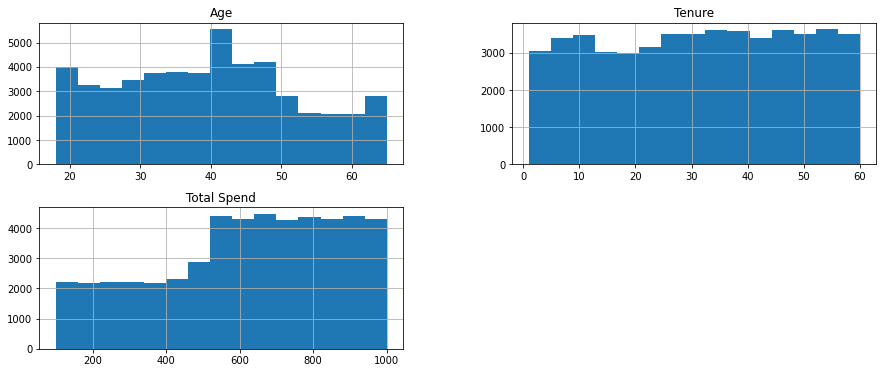

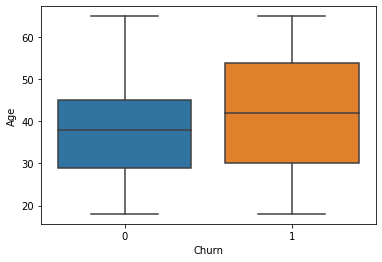

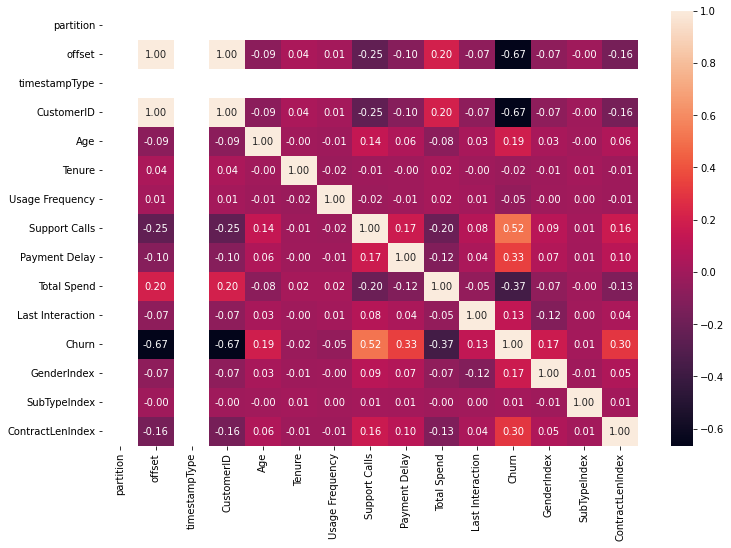

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for numerical features
sampled_pd_df[['Age', 'Tenure', 'Total Spend']].hist(bins=15, figsize=(15, 6))
plt.show()

# Boxplot for 'Age' by 'Churn'
sns.boxplot(x='Churn', y='Age', data=sampled_pd_df)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sampled_pd_df.corr(), annot=True, fmt=".2f")
plt.show()


In [0]:
import pandas as pd

def find_outliers_iqr(df, numerical_columns):
    Q1 = df[numerical_columns].quantile(0.25)
    Q3 = df[numerical_columns].quantile(0.75)
    IQR = Q3 - Q1
    
    outliers = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR)))
    outliers_count = outliers.sum()
    
    return outliers_count



In [0]:
numerical_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
outliers_per_column = find_outliers_iqr(sampled_pd_df, numerical_cols)
print("Number of outliers per column:")
print(outliers_per_column.sort_values(ascending=False))


Number of outliers per column:
Age                 0
Tenure              0
Usage Frequency     0
Support Calls       0
Payment Delay       0
Total Spend         0
Last Interaction    0
dtype: int64


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Exclude non-numeric columns
numerical_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']

# Sample the data (if not already sampled)
sampled_X = sampled_pd_df[numerical_cols]

# Initialize the scaler
scaler = StandardScaler()

# Scale the data
X_scaled = scaler.fit_transform(sampled_X)

# Perform PCA to explain 95% of the variance
pca = PCA(n_components=0.95)

# Fit and transform the scaled data
X_pca = pca.fit_transform(X_scaled)

# How many components are we left with?
print(f"Number of components: {pca.n_components_}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, sampled_pd_df['Churn'], test_size=0.2, random_state=42)

# Now, X_train, X_test, y_train, y_test contain the scaled and PCA-transformed data ready for modeling.


Number of components: 7


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the logistic regression model
logistic_regression = LogisticRegression(random_state=42)

# Fit the model to the training data
logistic_regression.fit(X_train, y_train)

# Predict the churn on the test data
y_pred = logistic_regression.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of Logistic Regression: {accuracy:.2f}")


Accuracy of Logistic Regression: 0.82


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier model
random_forest = RandomForestClassifier(random_state=42)

# Fit the model to the training data
random_forest.fit(X_train, y_train)

# Predict the churn on the test data
y_pred = random_forest.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of Random Forest Classifier: {accuracy:.2f}")


Accuracy of Random Forest Classifier: 0.89


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree classifier model
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
decision_tree.fit(X_train, y_train)

# Predict the churn on the test data
y_pred = decision_tree.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of Decision Tree Classifier: {accuracy:.2f}")


Accuracy of Decision Tree Classifier: 0.81


In [0]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier model
svm_classifier = SVC(kernel='linear', random_state=42)

# Fit the model to the training data
svm_classifier.fit(X_train, y_train)

# Predict the churn on the test data
y_pred_svm = svm_classifier.predict(X_test)

# Calculate the accuracy of the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"Accuracy of SVM Classifier: {accuracy_svm:.2f}")


Accuracy of SVM Classifier: 0.82


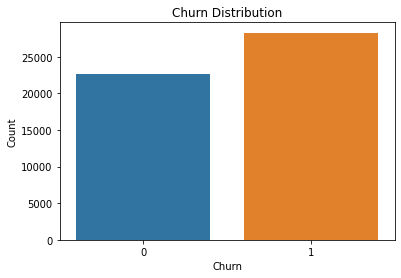

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=sampled_pd_df, x='Churn')
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


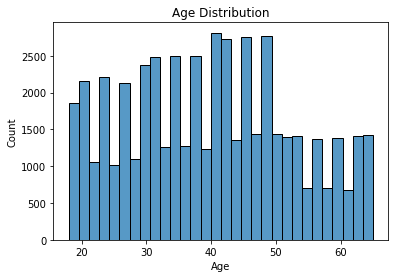

In [0]:
sns.histplot(data=sampled_pd_df, x='Age', bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


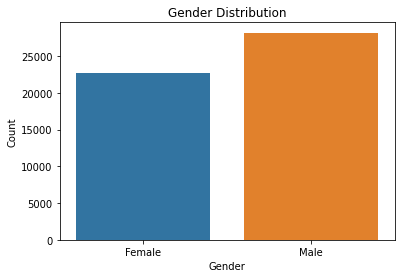

In [0]:
sns.countplot(data=sampled_pd_df, x='Gender')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


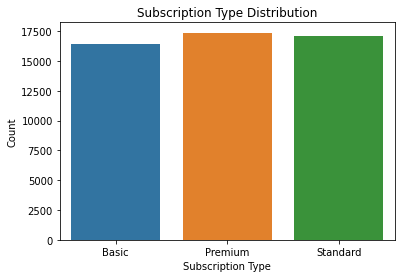

In [0]:
sns.countplot(data=sampled_pd_df, x='Subscription Type')
plt.title('Subscription Type Distribution')
plt.xlabel('Subscription Type')
plt.ylabel('Count')
plt.show()


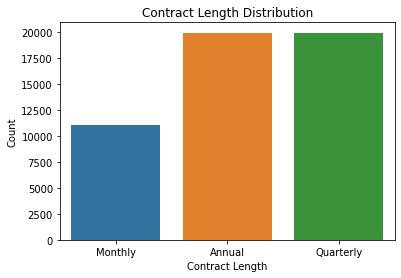

In [0]:
sns.countplot(data=sampled_pd_df, x='Contract Length')
plt.title('Contract Length Distribution')
plt.xlabel('Contract Length')
plt.ylabel('Count')
plt.show()


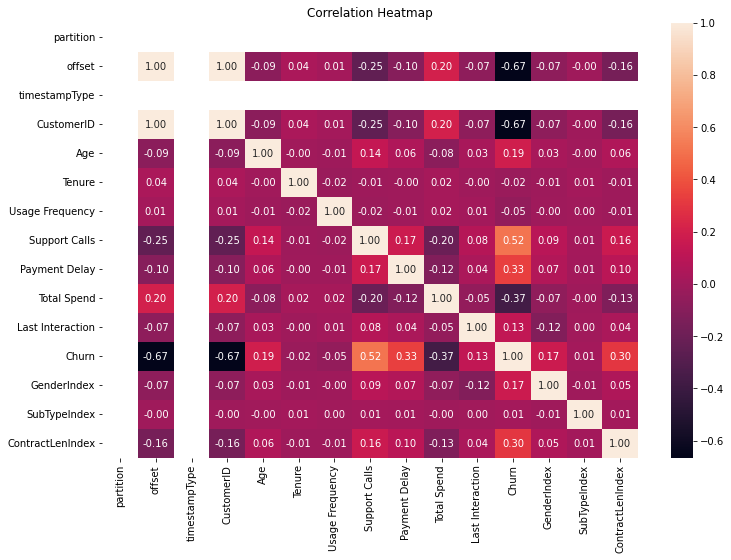

In [0]:
plt.figure(figsize=(12, 8))
sns.heatmap(sampled_pd_df.corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


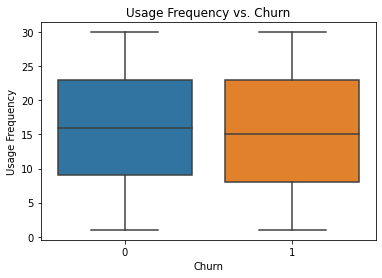

In [0]:
sns.boxplot(data=sampled_pd_df, x='Churn', y='Usage Frequency')
plt.title('Usage Frequency vs. Churn')
plt.xlabel('Churn')
plt.ylabel('Usage Frequency')
plt.show()


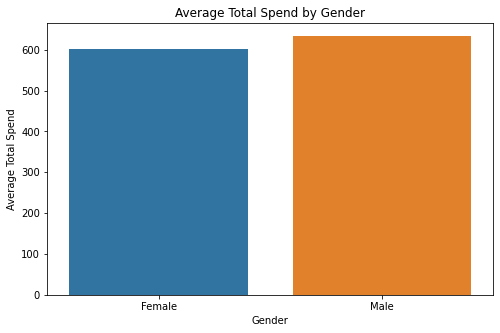

In [0]:
# Calculate average total spend by gender
avg_total_spend_by_gender = sampled_pd_df.groupby('Gender')['Total Spend'].mean().reset_index()

# Visualize the average total spend by gender
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_total_spend_by_gender, x='Gender', y='Total Spend')
plt.title('Average Total Spend by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Total Spend')
plt.show()


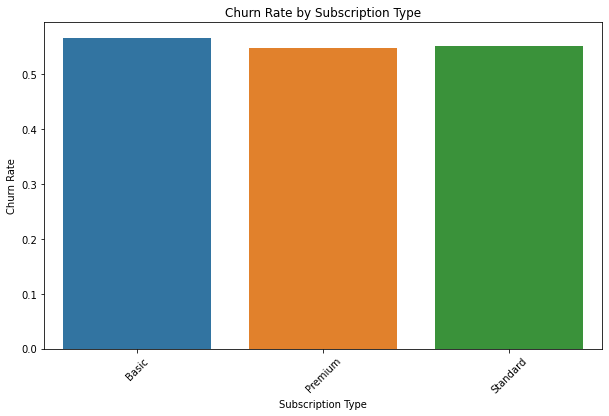

In [0]:
# Calculate churn rate by subscription type
churn_rate_by_sub_type = sampled_pd_df.groupby('Subscription Type')['Churn'].mean().reset_index()

# Visualize the churn rate by subscription type
plt.figure(figsize=(10, 6))
sns.barplot(data=churn_rate_by_sub_type, x='Subscription Type', y='Churn')
plt.title('Churn Rate by Subscription Type')
plt.xlabel('Subscription Type')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()


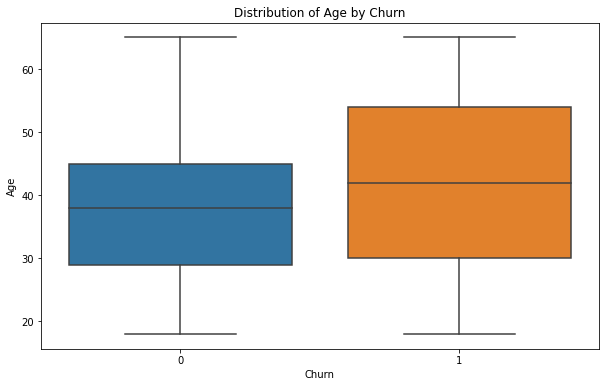

In [0]:
# Visualize the distribution of age by churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=sampled_pd_df, x='Churn', y='Age')
plt.title('Distribution of Age by Churn')
plt.xlabel('Churn')
plt.ylabel('Age')
plt.show()


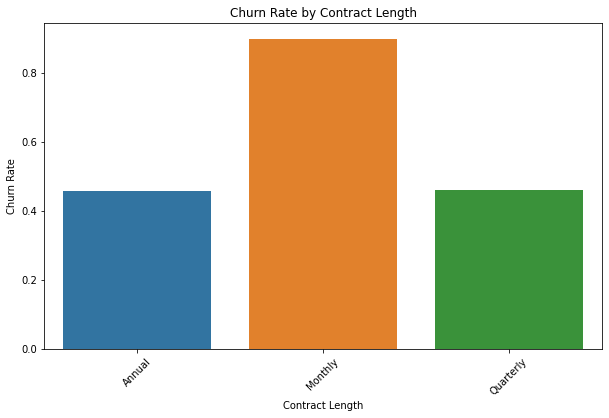

In [0]:
# Calculate churn rate by contract length
churn_rate_by_contract_len = sampled_pd_df.groupby('Contract Length')['Churn'].mean().reset_index()

# Visualize the churn rate by contract length
plt.figure(figsize=(10, 6))
sns.barplot(data=churn_rate_by_contract_len, x='Contract Length', y='Churn')
plt.title('Churn Rate by Contract Length')
plt.xlabel('Contract Length')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()


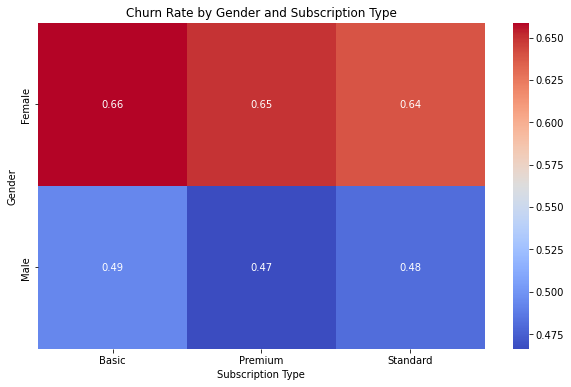

In [0]:
# Calculate churn rate by gender and subscription type
churn_rate_by_gender_sub_type = sampled_pd_df.groupby(['Gender', 'Subscription Type'])['Churn'].mean().reset_index()

# Pivot the table for visualization
pivot_churn_rate = churn_rate_by_gender_sub_type.pivot('Gender', 'Subscription Type', 'Churn')

# Visualize churn rate by gender and subscription type
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_churn_rate, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Churn Rate by Gender and Subscription Type')
plt.xlabel('Subscription Type')
plt.ylabel('Gender')
plt.show()


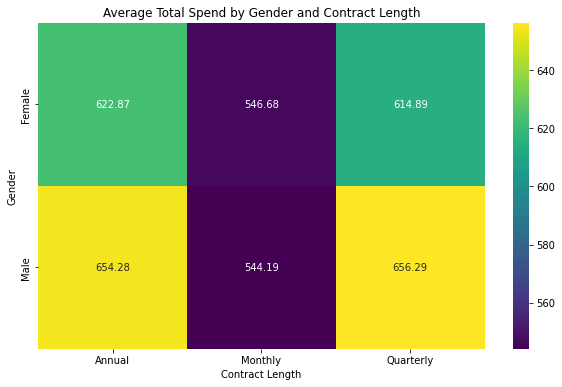

In [0]:
# Calculate average total spend by gender and contract length
avg_total_spend_by_gender_contract_len = sampled_pd_df.groupby(['Gender', 'Contract Length'])['Total Spend'].mean().reset_index()

# Pivot the table for visualization
pivot_avg_total_spend = avg_total_spend_by_gender_contract_len.pivot('Gender', 'Contract Length', 'Total Spend')

# Visualize average total spend by gender and contract length
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_avg_total_spend, annot=True, cmap='viridis', fmt='.2f')
plt.title('Average Total Spend by Gender and Contract Length')
plt.xlabel('Contract Length')
plt.ylabel('Gender')
plt.show()


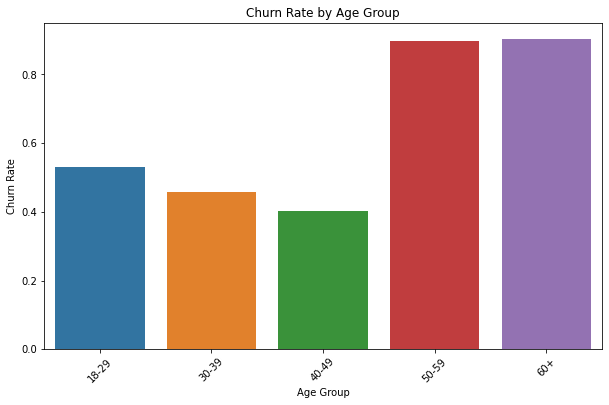

In [0]:
# Create age groups
bins = [18, 30, 40, 50, 60, 100]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']
sampled_pd_df['Age Group'] = pd.cut(sampled_pd_df['Age'], bins=bins, labels=labels)

# Calculate churn rate by age group
churn_rate_by_age_group = sampled_pd_df.groupby('Age Group')['Churn'].mean().reset_index()

# Visualize churn rate by age group
plt.figure(figsize=(10, 6))
sns.barplot(data=churn_rate_by_age_group, x='Age Group', y='Churn', order=labels)
plt.title('Churn Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()


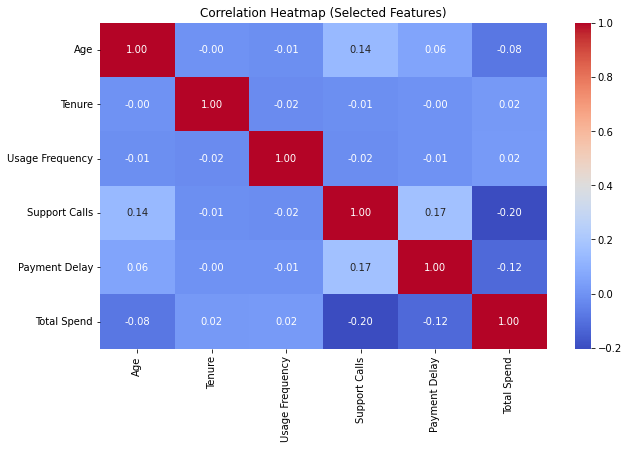

In [0]:
# Select a subset of numerical features for correlation
selected_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend']

# Calculate the correlation matrix for selected features
corr_matrix = sampled_pd_df[selected_features].corr()

# Visualize the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Selected Features)')
plt.show()


<Figure size 720x432 with 0 Axes>

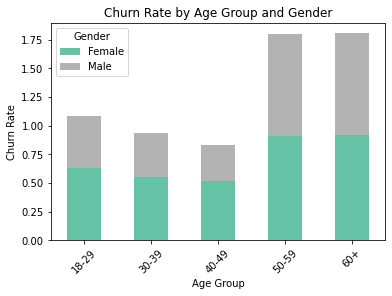

In [0]:
# Calculate churn rate by age group and gender
churn_rate_by_age_group_gender = sampled_pd_df.groupby(['Age Group', 'Gender'])['Churn'].mean().reset_index()

# Pivot the table for visualization
pivot_churn_rate_age_group_gender = churn_rate_by_age_group_gender.pivot('Age Group', 'Gender', 'Churn')

# Visualize churn rate by age group and gender as a stacked bar chart
plt.figure(figsize=(10, 6))
pivot_churn_rate_age_group_gender.plot(kind='bar', stacked=True, cmap='Set2')
plt.title('Churn Rate by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.legend(title='Gender', loc='upper left')
plt.show()
